### Pix2Pix modeling

Model repo: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

Paper: https://arxiv.org/pdf/1611.07004.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float, img_as_ubyte, io, color
from skimage.measure import compare_ssim
from skimage.measure import compare_mse
from cellvision_lib import get_model_data_splits
# %pylab inline

In [2]:
# Proprocesing the data for pix2pix model
import os
import glob
from shutil import copyfile

MAX_DEPTH = 100
NUM_SAMPLES = 109

# folder_path = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized'
# train, test, val = train_test_val(folder_path, channels = 1, train_pp = .67, test_pp = .165, val_pp = .165, set_seed = 1)

# train[0:10]

def clear_test_files(pix2pix_path):
    print('Removing files at ' + pix2pix_path)
    outer_paths = ['A','B']
    inner_paths = ['test','train','val']
    for outer in outer_paths:
        for inner in inner_paths:
            files = glob.glob('{root}/{split}/{inner}/*'.format(root=pix2pix_path, split=outer, inner=inner))
            for f in files:
                os.remove(f)
    print('Done removing files.')
                
def setup_images_for_pix2pix(src_path, channel, num_images):
    print("Setting up {} images for channel {}".format(num_images, channel))
    pix_folder_path = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel{}_{}'.format(channel,num_images)
    print("At path " + pix_folder_path)
    clear_test_files(pix_folder_path)
    train, test, val = get_model_data_splits(src_path, 
                                      channel = channel, 
                                      train_pp = .67, 
                                      test_pp = .165, 
                                      val_pp = .165, 
                                      seed = 1)

    train_images = train[0:num_images]
    test_images = test[0:num_images]
    val_images = val[0:num_images]
    
    def get_pix_fname(base_dir, ref_fname, _channel, mode):
        fname = os.path.basename(comp)
        end_sample_prefix_index = fname.find('_channel{}_z'.format(channel)) 
        start_z_index = end_sample_prefix_index + 11
        end_index = fname.find('.tif') 
        sample_prefix = fname[0:end_sample_prefix_index]
        z_depth = fname[start_z_index:end_index]
        new_comp_path = '{}/A/{}/{}_channel{}_z{}.jpg'.format(base_dir, mode, sample_prefix, _channel, z_depth)
        new_ref_path = '{}/B/{}/{}_channel{}_z{}.jpg'.format(base_dir, mode, sample_prefix, _channel, z_depth)
        if not os.path.exists('{}/A/{}'.format(base_dir,mode)):
            os.makedirs('{}/A/{}'.format(base_dir,mode))
        if not os.path.exists('{}/B/{}'.format(base_dir,mode)):
            os.makedirs('{}/B/{}'.format(base_dir,mode))
        return new_comp_path, new_ref_path
    
    for i, (comp, ref) in enumerate(train_images):
        new_comp_path, new_ref_path = get_pix_fname(pix_folder_path, ref, channel, "train")
        copyfile(comp, new_comp_path)
        copyfile(ref, new_ref_path)
        
    print("done with training images")
    
    for i, (comp, ref) in enumerate(test_images):
        new_comp_path, new_ref_path = get_pix_fname(pix_folder_path, ref, channel, "test")
        copyfile(comp, new_comp_path)
        copyfile(ref, new_ref_path)
        
    print("done with testing images")
        
    for i, (comp, ref) in enumerate(val_images):
        new_comp_path, new_ref_path = get_pix_fname(pix_folder_path, ref, channel, "val")
        copyfile(comp, new_comp_path)
        copyfile(ref, new_ref_path)
        
    print("done with validation images")


folder_path = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50'
# folder_path = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized'

setup_images_for_pix2pix(folder_path, 1, 100)
# setup_images_for_pix2pix(folder_path, 2, 500)
# setup_images_for_pix2pix(folder_path, 3, 500)
# setup_images_for_pix2pix(folder_path, 4, 500)
# setup_images_for_pix2pix(folder_path, 5, 500)

# print()
# print(glob.glob('/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1/A/train/*'))
# print()
# print(glob.glob('/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1/B/train/*'))


Setting up 100 images for channel 1
At path /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_100
Removing files at /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_100
Done removing files.
done with training images
done with testing images
done with validation images


In [ ]:
"""
Commands to run with the pix2pix framework

python datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/testing/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/testing/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/testing --num_imgs 200

python datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000 --num_imgs 1000

bsub -Is -o fold_1_100.txt python datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_100/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_100/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_100 --num_imgs 100



bsub -o fold_1_500.txt python datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_500/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_500/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_500 --num_imgs 500
bsub -o fold_2_500.txt python datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel2_500/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel2_500/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel2_500 --num_imgs 500
bsub -o fold_3_500.txt python datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel3_500/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel3_500/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel3_500 --num_imgs 500
bsub -o fold_4_500.txt python datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel4_500/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel4_500/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel4_500 --num_imgs 500
bsub -o fold_5_500.txt python datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel5_500/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel5_500/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel5_500 --num_imgs 500


bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o log_channeltest_jobout.txt python train.py --save_epoch_freq 50 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_100 --name cellvision_channeltest --model pix2pix --direction AtoB --gpu 0 --display_id 0 --loadSize 512 --fineSize 512
bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o channel2_100_jobout.txt python train.py --save_epoch_freq 50 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel2_100 --name cellvision_channel2_100 --model pix2pix --direction AtoB --gpu 0 --display_id 0 --resize_or_crop none

bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o channeltesting_jobout.txt python train.py --save_epoch_freq 25 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000 --name cellvision_testing --model pix2pix --direction AtoB --gpu 0 --display_id 0


bsub -Is -gpu "num=1:mode=exclusive_process:mps=yes" python test.py --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_100 --name cellvision_channeltest --model pix2pix --direction AtoB --num_test 100 --phase val --loadSize 512 --fineSize 512

bsub -o val2_500.txt -gpu "num=1:mode=exclusive_process:mps=yes" python test.py --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel2_500 --name cellvision_channel2_500 --model pix2pix --direction AtoB --num_test 500 --phase val
bsub -o val3_500.txt -gpu "num=1:mode=exclusive_process:mps=yes" python test.py --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel3_500 --name cellvision_channel3_500 --model pix2pix --direction AtoB --num_test 500 --phase val
bsub -o val4_500.txt -gpu "num=1:mode=exclusive_process:mps=yes" python test.py --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel4_500 --name cellvision_channel4_500 --model pix2pix --direction AtoB --num_test 500 --phase val
bsub -o val5_500.txt -gpu "num=1:mode=exclusive_process:mps=yes" python test.py --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel5_500 --name cellvision_channel5_500 --model pix2pix --direction AtoB --num_test 500 --phase val


"""

In [5]:
import glob
import os

channels = list(range(1,6))
sample_sizes =[500]

result_path = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results'

results_dirs = []
mses = []
ssims = []
for sample_size in sample_sizes:
    sub_results = []
    mses_sub = []
    ssim_sub = []
    for channel in channels:
        print("Getting MSE and SSIM for sample size {} and channel {}".format(sample_size, channel))
        result_dir = '{}/cellvision_channel{}_{}/val_latest/images'.format(result_path, channel, sample_size)
        print(result_dir)
        real_path_low = '{}/*_real_A.png'.format(result_dir)
        real_low_imgs = glob.glob(real_path_low)
        print("getting {} images".format(len(real_low_imgs)))
        channel_mse = []
        channel_ssim = []
        for real_path_low in real_low_imgs:
            fname = os.path.basename(real_path_low)
            fname_prefix = fname[:-11]
            real_path_high = '{}/{}_real_B.png'.format(result_dir, fname_prefix)
            fake_path = '{}/{}_fake_B.png'.format(result_dir, fname_prefix)
            try:
                real_img_high = color.rgb2gray(io.imread(real_path_high).astype(np.uint))
                real_img_low = color.rgb2gray(io.imread(real_path_low).astype(np.uint))
                fake_img = color.rgb2gray(io.imread(fake_path).astype(np.uint))
            except OSError:
                print("OSERROR skipping " + fake_path)
            
            _min = real_img_high.min()
            _max = real_img_high.max()

            low_high_ssim = compare_ssim(real_img_low, real_img_high, data_range=_max-_min)
            fake_high_ssim = compare_ssim(fake_img, real_img_high, data_range=_max-_min)
            channel_ssim.append( (low_high_ssim,fake_high_ssim) )

            low_high_mse = compare_mse(real_img_low, real_img_high)
            fake_high_mse = compare_mse(fake_img, real_img_high)
            channel_mse.append( (low_high_mse,fake_high_mse) )
        
        mses_sub.append(channel_mse)
        ssim_sub.append(channel_ssim)
    mses.append(mses_sub)
    ssims.append(ssim_sub)

print(len(mses[0][0][0]))
# results_dir = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision5/test_latest/images'

# out_imgs = glob.glob(results_dir)


Getting MSE and SSIM for sample size 500 and channel 1
/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel1_500/val_latest/images
getting 500 images
Getting MSE and SSIM for sample size 500 and channel 2
/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel2_500/val_latest/images
getting 500 images
Getting MSE and SSIM for sample size 500 and channel 3
/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel3_500/val_latest/images
getting 500 images
Getting MSE and SSIM for sample size 500 and channel 4
/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel4_500/val_latest/images
getting 500 images
Getting MSE and SSIM for sample size 500 and channel 5
/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel5_500/val_latest/images
getting 500 images
2


In [54]:
print(len(ssims))
print(len(ssims[0]))
print(len(ssims[0][0]))
# ssims[0][0]

NameError: name 'ssims' is not defined

In [7]:
import statistics

low_means = []
fake_means = []
for sample_size in ssims:
    for channel in sample_size:
        low = [ssim[0] for ssim in channel]
        print(len(low))
        low_std = statistics.stdev(low)
        low_mean = statistics.mean(low)
        print(low_mean)
        low_means.append(low_mean)

        fake = [ssim[1] for ssim in channel]
        fake_std = statistics.stdev(fake)
        fake_mean = statistics.mean(fake)
        fake_means.append(fake_mean)


print("Low ssim mean {} with std {}".format(low_mean,low_std))
print("Fake ssim mean {} with std {}".format(fake_mean,fake_std))

# low_mse = [mse[0] for mse in mses]
# low_std_mse = statistics.stdev(low_mse)
# low_mean_mse = statistics.mean(low_mse)

# fake_mse = [mse[1] for mse in mses]
# fake_std_mse = statistics.stdev(fake_mse)
# fake_mean_mse = statistics.mean(fake_mse)
# print()
# print("Low mse mean {} with std {}".format(low_mean_mse,low_std_mse))
# print("Fake mse mean {} with std {}".format(fake_mean_mse,fake_std_mse))


500
0.02486735948582183
500
0.03883570519013288
500
0.4334226671518876
500
0.6786831404674616
500
0.7277165273952351
Low ssim mean 0.7277165273952351 with std 0.1466544277731143
Fake ssim mean 0.7048083727723172 with std 0.13700941445086687


In [9]:
low_means

[0.02486735948582183,
 0.03883570519013288,
 0.4334226671518876,
 0.6786831404674616,
 0.7277165273952351]

In [10]:
fake_means

[0.542089543287763,
 0.5592069445590415,
 0.6252987301860703,
 0.663344139307484,
 0.7048083727723172]

/gpfs/share/skynet/apps/anaconda3/envs/pytorch-env/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


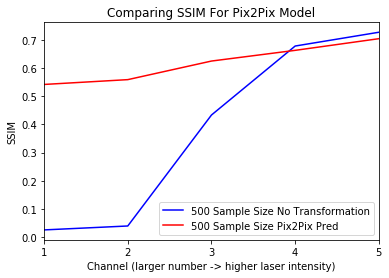

In [11]:
# Comparing MSE for denoising
plt.plot(list(range(1, 6)), low_means[0:5], label="500 Sample Size No Transformation", color='blue') 
plt.plot(list(range(1, 6)), fake_means[0:5], label="500 Sample Size Pix2Pix Pred", color='red') 
# plt.plot(list(range(1, 6)), low_means[5:10], label="1000 Sample Size No Transformation", color='purple') 
# plt.plot(list(range(1, 6)), fake_means[5:10], label="1000 Sample Size Prediction", color='green') 

plt.title('Comparing SSIM For Pix2Pix Model')
plt.legend(loc = 'lower right')
# plt.ylim([0, 1])
plt.xlim([1, 5])
plt.axes().set_xticks(list(range(1, 6)), minor=False)

plt.ylabel('SSIM')
plt.xlabel('Channel (larger number -> higher laser intensity)')
plt.show()

In [ ]:
# Showing images
from skimage import exposure
path_to_data = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel1_1000/test_latest/images/sample112_channel1_z34_real_A.png'
imsk_A = io.imread(path_to_data)
imsk_A = exposure.rescale_intensity(imsk_A,in_range=(0,np.max(imsk_A)))
path_to_data = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel1_1000/test_latest/images/sample112_channel1_z34_real_B.png'
imsk_B = io.imread(path_to_data)
imsk_B = exposure.rescale_intensity(imsk_B,in_range=(0,np.max(imsk_B)))
path_to_data = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel1_1000/test_latest/images/sample112_channel1_z34_fake_B.png'
fake = io.imread(path_to_data)
fake = exposure.rescale_intensity(fake,in_range=(0,np.max(fake)))
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(25,5))
# ax[0].imshow(imsk_nl[0]);
ax[0].imshow(imsk_A);
ax[0].axis('off')
ax[1].imshow(imsk_B);
ax[1].axis('off')
ax[2].imshow(fake);
ax[2].axis('off')
plt.show()

In [ ]:
path_to_data = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel1_1000/test_latest/images/sample112_channel1_z34_real_A.png'
imsk_A = io.imread(path_to_data)
imsk_A = exposure.rescale_intensity(imsk_A,in_range=(0,np.max(imsk_A)))
path_to_data = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel1_1000/test_latest/images/sample112_channel1_z34_real_B.png'
imsk_B = io.imread(path_to_data)
imsk_B = exposure.rescale_intensity(imsk_B,in_range=(0,np.max(imsk_B)))
path_to_data = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000/test/sample61_channel1_z48.jpg'
fake = io.imread(path_to_data)
fake = exposure.rescale_intensity(fake,in_range=(0,np.max(fake)))
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(25,5))
# ax[0].imshow(imsk_nl[0]);
ax[0].imshow(imsk_A);
ax[0].axis('off')
ax[1].imshow(imsk_B);
ax[1].axis('off')
ax[2].imshow(fake);
ax[2].axis('off')
plt.show()

(512, 512)
(512, 512)
(512, 1024, 3)
(512, 1024, 3)
(512, 512, 3)
(512, 512)


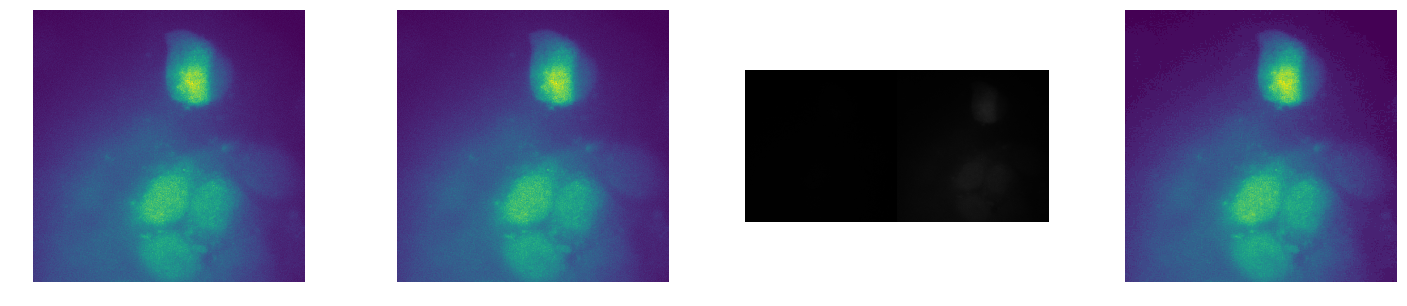

1.0

In [49]:
import cv2

path_to_data = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample114_channel6_z10.tif'
skimage_original = io.imread(path_to_data).astype(np.uint)
print(skimage_original.shape)
cv_original = cv2.imread(path_to_data, cv2.COLOR_BGR2GRAY)
print(cv_original.shape)

path_to_data = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_100/val/sample114_channel1_z10.jpg'
fold_out = io.imread(path_to_data)
print(fold_out.shape)
cv_fold = cv2.imread(path_to_data, cv2.COLOR_BGR2GRAY)
print(cv_fold.shape)

path_to_data = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channeltest/val_latest/images/sample114_channel1_z10_real_B.png'
result_io = io.imread(path_to_data)
print(result_io.shape)
# im_A = cv2.imread(path_to_data)
result_io_sk = cv2.imread(path_to_data, cv2.IMREAD_GRAYSCALE)
print(result_io_sk.shape)

# print(imsk_B.shape)
# print(im_A.shape)

# fake = exposure.rescale_intensity(fake,in_range=(0,np.max(fake)))
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(25,5))
# ax[0].imshow(imsk_nl[0]);
ax[0].imshow(skimage_original);
ax[0].axis('off')
ax[1].imshow(cv_original);
ax[1].axis('off')
ax[2].imshow(fold_out);
ax[2].axis('off')
ax[3].imshow(result_io_sk);
ax[3].axis('off')
plt.show()

low_high_ssim = compare_ssim(skimage_original, img_as_uint(result_io_sk))
low_high_ssim

In [50]:
from skimage import data, img_as_float, img_as_ubyte, io, img_as_int, img_as_uint
print(skimage_original.shape)
print(result_io_sk.shape)

print(skimage_original)
print(img_as_uint(result_io_sk).T)

(512, 512)
(512, 512)
[[ 361  349  393 ...  355  354  281]
 [ 366  390  309 ...  413  331  361]
 [ 414  405  374 ...  320  305  369]
 ...
 [1521 1682 1757 ...  767  860  648]
 [1727 1730 1681 ...  810  918  845]
 [1759 1620 1600 ...  782  772  721]]
[[   0    0    0 ... 1028 1028 1285]
 [   0    0    0 ... 1285 1028 1285]
 [   0    0    0 ... 1285 1285 1285]
 ...
 [   0    0    0 ...  514  514  514]
 [   0    0    0 ...  514  514  514]
 [   0    0    0 ...  514  514  257]]


In [53]:
import cv2

path_to_data = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channeltest/val_latest/images/sample114_channel1_z10_real_B.png'
skimage = io.imread(path_to_data).astype(np.uint)
print(skimage.shape)

cv_image = cv2.imread(path_to_data, cv2.IMREAD_GRAYSCALE)
print(cv_image.shape)
# flow_img = cv2.cvtColor(im_A, cv2.COLOR_RGB2BGR)
# RGB_img = cv2.cvtColor(im_A, cv2.COLOR_BGR2RGB)

path_to_data_B = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample114_channel6_z10.tif'
skimage_original = io.imread(path_to_data_B).astype(np.uint)
# imsk_B = io.imread(path_to_data_B)
print(skimage_original.shape)

_min = cv_image.min()
_max = cv_image.max()

low_high_ssim = compare_ssim(skimage_original, img_as_uint(cv_image))
low_high_ssim

(512, 512, 3)
(512, 512)
(512, 512)


1.0